# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://learn.wbscodingschool.com/courses/data-science/lessons/%f0%9f%93%9d-5-data-quality/) and use what you've learnt to see how reliable the data is.

In [100]:
import pandas as pd

Load our cleaned DataFrames

In [101]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [102]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)

## 2.&nbsp; Exclude unwanted orders

In [103]:
orderlines_cl = orderlines_cl.rename(columns={'id_order': 'order_id'})

In [104]:
common_order_ids = pd.Index(orders_cl['order_id']).intersection(orderlines_cl['order_id'])
orders_cl = orders_cl[orders_cl['order_id'].isin(common_order_ids)]
orderlines_cl = orderlines_cl[orderlines_cl['order_id'].isin(common_order_ids)]


## 3.&nbsp; Exclude orders with unknown products


In [105]:

common_sku = pd.Index(orderlines_cl['sku']).intersection(products_cl['sku'])
orderlines_cl = orderlines_cl[orderlines_cl['sku'].isin(common_sku)]

print(orderlines_cl)

             id  order_id  product_id  product_quantity      sku  unit_price  \
0       1119109    299539           0                 1  OTT0133       18.99   
1       1119110    299540           0                 1  LGE0043      399.00   
2       1119111    299541           0                 1  PAR0071      474.05   
3       1119112    299542           0                 1  WDT0315       68.39   
4       1119113    299543           0                 1  JBL0104       23.74   
...         ...       ...         ...               ...      ...         ...   
216245  1650199    527398           0                 1  JBL0122       42.99   
216246  1650200    527399           0                 1  PAC0653      141.58   
216247  1650201    527400           0                 2  APP0698        9.99   
216248  1650202    527388           0                 1  BEZ0204       19.99   
216249  1650203    527401           0                 1  APP0927       13.99   

                       date  
0       2

## 4.&nbsp; Explore the revenue from different tables

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [106]:
unit_price_total = orderlines_cl.unit_price * orderlines_cl.product_quantity

print(unit_price_total)

0         18.99
1        399.00
2        474.05
3         68.39
4         23.74
          ...  
216245    42.99
216246   141.58
216247    19.98
216248    19.99
216249    13.99
Length: 209510, dtype: float64


#### Step 2:
Group by `id_order`, summarising by the sum of `unit_price_total`

In [96]:
orderlines_cl['unit_price_total'] = orderlines_cl['unit_price'] * orderlines_cl['product_quantity']

# Group by id_order and sum the unit_price_total
order_revenue = orderlines_cl.groupby('order_id', as_index=False)['unit_price_total'].sum()

# Display the resulting DataFrame
print(order_revenue)

        order_id  unit_price_total
0         241319             44.99
1         241423            129.16
2         242832             10.77
3         243330             77.99
4         243784            153.87
...          ...               ...
166139    527397             42.99
166140    527398             42.99
166141    527399            141.58
166142    527400             19.98
166143    527401             13.99

[166144 rows x 2 columns]


### What is the average difference between `total_paid` and `unit_price_total`?

In [97]:
order_totals = orderlines_cl.groupby('order_id', as_index=False)['unit_price_total'].sum()

# Step 2: Merge aggregated totals into orders_cl
merged_orders = orders_cl.merge(order_totals, on='order_id', how='left')

# Step 3: Calculate the difference
merged_orders['difference'] = merged_orders['total_paid'] - merged_orders['unit_price_total']

# Step 4: Calculate the average difference
average_diff = merged_orders['difference'].mean()

# Output the average difference
print(f"The difference is: {average_diff}")

The difference is: 4.8732154636941445


### What is the distribution of these differences?

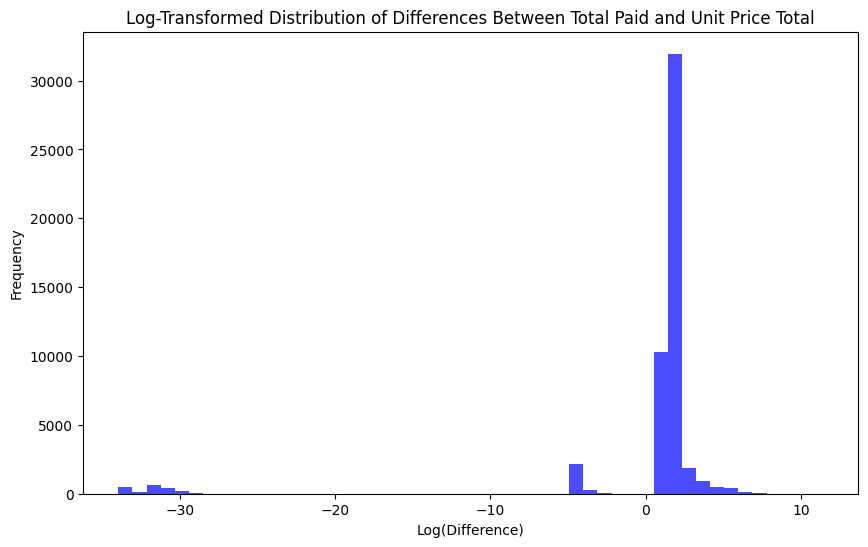

count   50552.00
mean        0.29
std         6.55
min       -33.96
25%         1.38
50%         1.61
75%         1.94
max        11.42
Name: log_difference, dtype: float64


In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Apply log transformation (ignoring zero and negative values for log transformation)
merged_orders['log_difference'] = merged_orders['difference'].apply(lambda x: np.log(x) if x > 0 else np.nan)

# Plot the histogram with log-transformed values
plt.figure(figsize=(10, 6))

# Histogram with log scale for differences
plt.hist(merged_orders['log_difference'].dropna(), bins=50, color='blue', alpha=0.7)
plt.title('Difference between total_paid and unit_price_total')
plt.xlabel('Log(Difference)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Display the summary statistics for the log-transformed differences
log_difference_stats = merged_orders['log_difference'].describe()
print(log_difference_stats)

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

1. Discounts or Promotions
    Applied Discounts: The total_paid amount might include discounts, promotions, or special offers that reduce the original price of the items. The unit_price_total might reflect the total price without any discounts.
    Conditional Promotions: In some cases, promotions like "buy one, get one free" or volume discounts may not be reflected in the unit price at the time of purchase but are applied later in the process.

Example: The customer pays less due to a promo code, but the system calculates unit_price_total without considering the discount.
2. Shipping or Handling Fees

    Separate Charges: The total_paid might include additional costs like shipping, taxes, or handling fees, which are not included in the unit_price_total. If the total payment is higher than the product price alone, this can explain the difference.

Example: The total paid by the customer includes shipping fees, taxes, or other additional charges, but the unit price reflects only the product price.
3. Rounding Differences

    Rounding: Sometimes, differences arise due to rounding methods. Prices might be rounded to two decimal places during payment processing, but the unit_price_total calculation may not account for this rounding, leading to slight discrepancies.

Example: The system may calculate prices using a full precision value, but during payment, rounding to two decimal places could introduce a small difference.
4. Returns or Cancellations

    Order Cancellations or Partial Returns: If an order has been partially returned or canceled, the total_paid may reflect a refund or reduction in price, while the unit_price_total could still reflect the original price before the adjustment.

Example: A customer returns one of the items in an order, and the refund is reflected in total_paid but not in unit_price_total.
5. Currency Conversion

    Currency Mismatch: If the unit_price_total is calculated in one currency and the total_paid is recorded in another (e.g., the product price is in USD, and the payment is made in EUR), the conversion rates at the time of payment could cause differences.

Example: Currency conversion rates fluctuate, leading to differences between the total amount paid and the calculated unit price.
6. System Errors or Bugs

    Inaccurate Data Entry or Calculation Errors: There could be issues with how data is entered into the system or how the total prices are calculated. This could be due to an error in the software, such as missing fields, miscalculations, or bugs in the pricing algorithm.

Example: A software bug or glitch could result in the unit_price_total not being calculated correctly, leading to discrepancies with the total_paid.
7. Taxes or Fees Included in Total Paid

    Sales Tax or Service Charges: Some orders include taxes, service charges, or other fees, which are reflected in the total_paid but not in the unit_price_total (which might reflect only the cost of the products themselves).

Example: Sales tax or VAT might be included in the total_paid, but the unit_price_total does not account for it.
8. Multiple Items with Varying Prices

    Multiple Products: In orders with multiple items, different product types or pricing structures may lead to discrepancies between the calculated unit_price_total and the actual total_paid. The sum of the unit prices for each item might differ from what the customer paid due to varied pricing on different items or product configurations.

Example: The unit_price_total may reflect the sum of the prices of individual items, but total_paid might reflect discounts or pricing adjustments applied to specific items in the order.
9. Late Fees or Additional Charges

    Unexpected Fees: There could be charges that are added after the initial order, such as late fees, penalty fees, or charges for extended warranties, which may not be included in the unit_price_total.

Example: A late fee or extended warranty added after the initial purchase could explain the difference between the total paid and the calculated unit price.

### If there are differences that you can’t explain: what should you do with these orders?

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

Empty DataFrame
Columns: [id, order_id, product_id, product_quantity, sku, unit_price, date, unit_price_total, weird_outliers]
Index: []


Do not forget to download your quality controlled DataFrames

In [ ]:
from google.colab import files

#orders_quality_controlled.to_csv("orders_qu.csv", index=False)
#files.download("orders_qu.csv")

#orderlines_quality_controlled.to_csv("orderlines_qu.csv", index=False)
#files.download("orderlines_qu.csv")